# Toy example : Model Choice with $Ma(q)$

## Definition of the model
$$x_{t}=\mu+\epsilon_{t}-\sum_{i=1}^{q} \vartheta_{i} \epsilon_{t-i}$$

In [1]:
import numpy as np

def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    w = np.random.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:,s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:,p],(batch_size,1)),n_obs,axis=1)*w[:, (s-p-1):(-p-1)]
    return x


## Priors constraint

For identifiability reasons, 

$$\mathcal{Q}(u)=1-\sum_{i=1}^{q} \vartheta_{i} u^{i}$$

should have only roots outside of the (complex) unity disc.

In [2]:
import math

def generate_maq_priors(q,min,max,batch_size=1):
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    nc = np.random.randint(q,size=batch_size)
    nd = np.random.randint(d,size=batch_size)
    r = np.random.uniform(min,max,(batch_size,1))
    genr = np.exp(np.random.dirichlet(np.ones(q),batch_size)*np.log(np.abs(1/r)))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:,-1] = -genr[:,-1]
    alphas = np.zeros((batch_size,q))
    for i in range(batch_size):
        gen = np.random.uniform(0,math.pi,nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq =  np.random.randint(d2)
        alphas[i,:nd[i]] = gen
        alphas[i,nd[i]:(2*nd[i])] = -gen
        alphas[i,-(2*nq+1):] = -1
    roots = np.zeros((batch_size,q),dtype=complex)
    roots.real = np.cos(alphas) 
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:,nc] = -roots[:,nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1 # Prior constraint checking
    poly = np.apply_along_axis(np.polynomial.polynomial.polyfromroots,1,roots).real[:,1:]
    return poly * np.reshape(r,(batch_size,1))


## Summary statistics 

Autocorrelations with lag from 1 to $p \ge q$ is recommended for $Ma(q)$ models.

In [3]:
from statsmodels.tsa.stattools import acf

def autocorr(x, to=1):
    C = np.zeros((x.shape[0],to))
    for i in range(x.shape[0]):
        C[i] = acf(x[i],True,nlags=to,fft=True)[1:]
    return C


## The observed data
generated by us, of course...

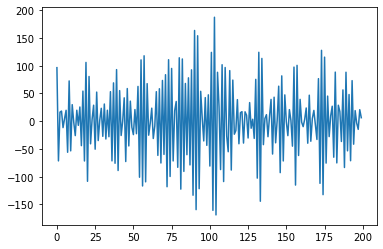

In [4]:
import matplotlib.pyplot as plt
minprior = 1
maxprior = 2
Ny = 200 # Length of the serie
Ncov = 20 # Maximum of autocorrelation lag
q = 10  # Our chosen q for the observed data
nref = 2000 # Number of expected simulated data from ABC
batchsize = 1000 

# Generation of the observed data
modsimple = generate_maq_priors(q,minprior,maxprior)
y_obs = MAq(modsimple,Ny)
plt.figure()
plt.plot(y_obs[0]);
#print('Thetas : ', modsimple[0])

## Setting the ABC pipeline

In [5]:
import elfi

Model choice tweak

In [6]:
qpriors = np.array([8,10,12])
nclasses = qpriors.shape[0]
maxt = np.max(qpriors)

In [7]:
def MAqn(qn,t,n_obs=10000, batch_size=1, random_state=None):
    res = np.zeros((batch_size,n_obs))
    for q in range(nclasses):
        qr = qpriors[q]
        res[qp == q,:qr] = MAq(t[qp == q,:qr],n_obs, batch_size=batch_size, random_state=random_state)
    return res

### Wrapping priors, custom classes

In [8]:
class ClassPrior(elfi.Distribution):
    def rvs(n,size=1,random_state=None):
        return np.random.randint(0,n,size=size)

class GlobalPrior(elfi.Distribution):
    def rvs(qp,min,max,size=1,random_state=None):
        class_count = np.zeros(nclasses,dtype='int')
        res = np.zeros((size[0],maxt))

        for q in range(nclasses):
            qr = qpriors[q]
            class_count[q] = np.sum(qp == q)
            res[qp == q,:qr] = generate_maq_priors(qr,min,max,class_count[q])
        return res

class DependantPrior(elfi.Distribution):
    def rvs(t,size=1,random_state=None):
        return np.mean(t,axis=1) 

First stages, prior dependancies

In [9]:
qp = elfi.Prior(ClassPrior,nclasses)
t  = elfi.Prior(GlobalPrior,qp,minprior,maxprior)
tm = elfi.Prior(DependantPrior,t)

Final stages, summary stats, simulator and distance

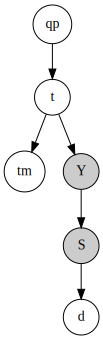

In [10]:
Y = elfi.Simulator(MAq,t, observed=y_obs)
S = elfi.Summary(autocorr,Y,Ncov)
d = elfi.Distance('euclidean',S)
elfi.draw(d)

In [11]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

### ABC samping

In [12]:
print('ABC sampling + rejection')
result = rej.sample(nref,threshold=10)

ABC sampling + rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [13]:
print("Class sampled repartition : ")
print([np.sum(result.samples['qp'] == i)/nref for i in range(nclasses)])

Class sampled repartition : 
[0.351, 0.343, 0.306]


# AbcRanger, posterior Model Choice

In [14]:
import sys
sys.path.insert(0,'../build')
import pyabcranger

def listvar(prefix,s):
    return [prefix+str(i) for i in range(1,s+1)]

rf = pyabcranger.reftable(
    nref,
    [np.sum(result.samples['qp'] == i) for i in range(nclasses)],
    qpriors,
    listvar('t',maxt),
    listvar('S',Ncov),
    result.outputs['S'],
    result.samples['t'],
    result.samples['qp']+1
)


In [15]:
postres = pyabcranger.modelchoice(rf, S.observed[0],"",False)
print('Predicted model  : q =', qpriors[postres.predicted_model])
print('votes : ', postres.votes)
print('Posterior probability : ', postres.post_proba)

///////////////////////////////////////// First forest (training on ABC output)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 1.6 kHz | 0s<0s]  
Computing prediction error ..
///////////////////////////////////////// Second forest (training on error)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 2.1 kHz | 0s<0s]  
Computing prediction error ..
 votes model1 votes model2 votes model3 selected model post proba
           70          325          105              2      0.984
Predicted model  : q = 10
votes :  [70, 325, 105]
Posterior probability :  0.984


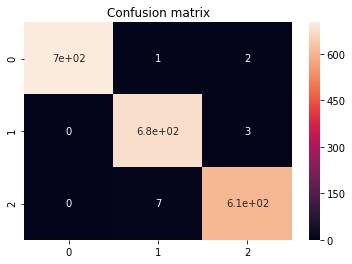

In [16]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(postres.confusion_matrix,range(nclasses),range(nclasses))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})
plt.title('Confusion matrix');

### Prior oob error (by number of tree)

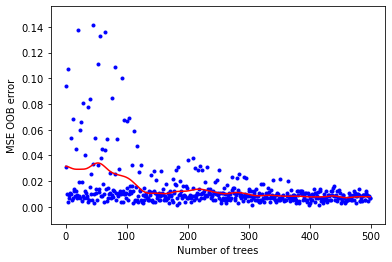

In [17]:
from scipy.ndimage.filters import gaussian_filter1d
ntree_oob_error_smoothed = gaussian_filter1d(postres.ntree_oob_error, sigma=10.0)
plt.figure()
plt.scatter(range(500),postres.ntree_oob_error,color='b',marker='.')
plt.plot(ntree_oob_error_smoothed,'r')
#plt.yscale('log')
plt.xlabel('Number of trees')
plt.ylabel('MSE OOB error');

### Variable importance

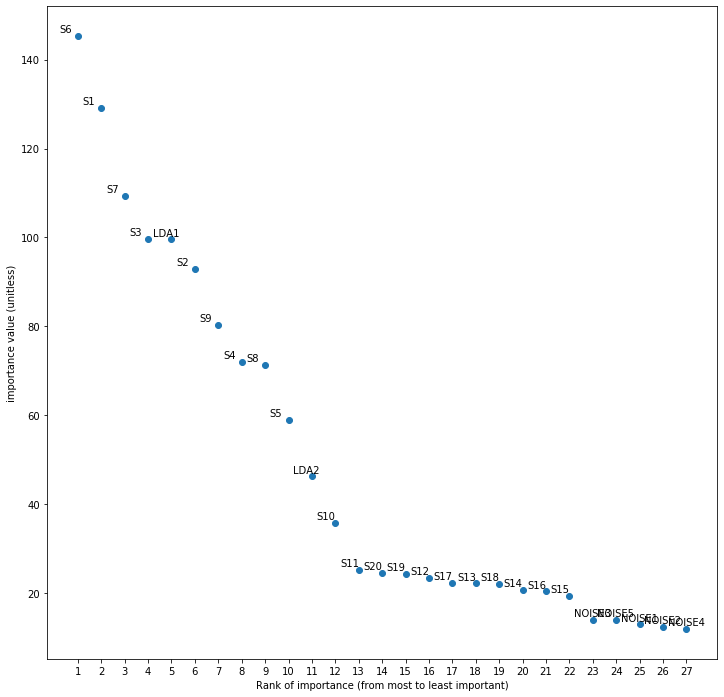

In [18]:
l  = len(postres.variable_importance)
#lr = range(l-1,-1,-1)
lr = range(l)
labels = [postres.variable_importance[i][0] for i in lr]
imp    = [postres.variable_importance[i][1] for i in lr]
plt.figure(figsize=(12, 12))
plt.scatter(range(1,len(postres.variable_importance)+1),imp)
plt.xticks(range(1,len(postres.variable_importance)+1))
for i in range(l):
    plt.text(i+0.2,imp[i]+0.8,labels[i])
plt.xlabel('Rank of importance (from most to least important)')
plt.ylabel('importance value (unitless)');